## Confidence sequences: anytime-valid inference
This notebook demonstrates anytime-valid inference for sequential monitoring:

- Confidence sequence (CS): a time-uniform confidence band that remains valid under optional stopping
- Anytime p-values: p-values that remain valid even if you stop based on what you see

Scope (v1):

- Two-group A/B, mean-difference (user-level)
- Normal approximation with empirical variance

Outputs:

- CS band across looks
- Anytime boundary / p-values across looks
- Example of safe stopping

Caveats:

- Assumes independence / weak dependence and CLT-like behavior
- For heavy tails / drift, see notebook 18

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tecore.sequential.schema import (
    SequentialSpec,
    LookSchedule,
    SequentialConfig,
    SequentialMode,
    EffectDirection,
)
from tecore.sequential.preprocess import build_look_table_mean
from tecore.sequential.confidence_sequences import run_confidence_sequence
from tecore.sequential.simulate import SequentialSimConfig, simulate_ab_stream

plt.rcParams["figure.figsize"] = (9, 5)
plt.rcParams["axes.grid"] = True

## 1) Single run: effect trajectory, fixed CI vs confidence sequence

In [3]:
N = 12000
looks = [1000, 2000, 4000, 6000, 8000, 10000, 12000]
alpha = 0.05

# Simulate a modest effect
df = simulate_ab_stream(SequentialSimConfig(n=N, effect=0.08, noise_sd=1.0, heavy_tail=False, drift=False, seed=21, ratio=False))

spec = SequentialSpec(group_col="group", control_label="control", test_label="test", y_col="y", timestamp_col="timestamp")
schedule = LookSchedule(looks=looks)
cfg_cs = SequentialConfig(
    mode=SequentialMode.CONFIDENCE_SEQUENCE,
    alpha=alpha,
    two_sided=True,
    effect_direction=EffectDirection.TWO_SIDED,
    min_n_per_group=50,
    var_floor=1e-12,
    seed=21,
)

lt, warn = build_look_table_mean(df, spec, schedule, cfg_cs)
res = run_confidence_sequence(lt, cfg_cs)

display(res.look_table.head())
print("Decision:", res.decision, "stopped=", res.stopped, "stop_look=", res.stop_look)

Decision: continue stopped= False stop_look= None


,n_control,n_test,mean_control,mean_test,var_control,var_test,diff,se,z,info,look_n,boundary_z,cs_low,cs_high,m_value,p_anytime,p_value,crossed
0,491,509,0.027575,0.045855,1.101958,0.957622,0.018280,0.064232,0.284599,242.383543,1000,3.396099,-0.199856,0.236417,1.000000,1.000000,1.000000,False
1,993,1007,0.007035,0.066735,1.101238,1.030928,0.059700,0.046182,1.292713,468.875593,2000,3.488529,-0.101407,0.220807,1.000000,1.000000,1.000000,False
2,1954,2046,0.038193,0.100145,1.019810,1.000814,0.061952,0.031797,1.948360,989.056040,4000,3.591971,-0.052262,0.176167,1.000000,1.000000,1.000000,False
3,2968,3032,0.022917,0.097572,1.017634,1.011529,0.074656,0.026009,2.870338,1478.226979,6000,3.646880,-0.020197,0.169509,1.595198,0.626881,0.626881,False
4,3981,4019,0.017755,0.092233,1.006046,1.010144,0.074478,0.022451,3.317341,1983.914453,8000,3.686685,-0.008292,0.157248,5.490051,0.182148,0.182148,False


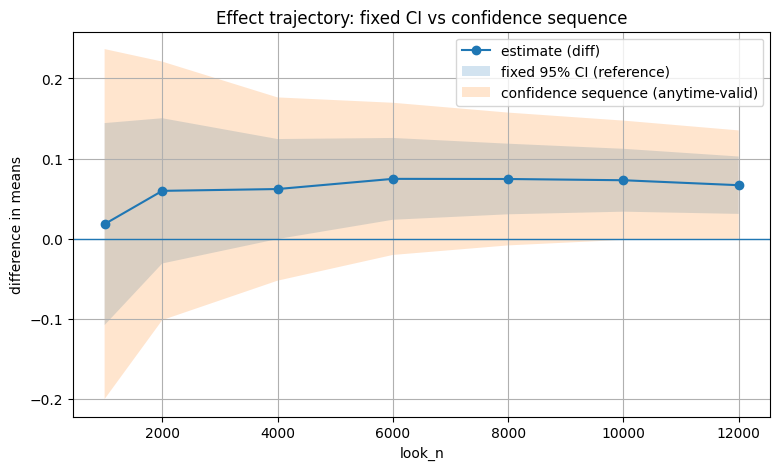

In [4]:
# Plot 1: effect estimate trajectory with fixed CI and CS band
tab = res.look_table.copy()
x = tab["look_n"].to_numpy(dtype=int)
est = tab["diff"].to_numpy(dtype=float)
se = tab["se"].to_numpy(dtype=float)

# Fixed-horizon 95% CI (for reference only; NOT anytime-valid)
z_fixed = 1.959963984540054
fix_lo = est - z_fixed * se
fix_hi = est + z_fixed * se

cs_lo = pd.to_numeric(tab.get("cs_low"), errors="coerce").to_numpy(dtype=float)
cs_hi = pd.to_numeric(tab.get("cs_high"), errors="coerce").to_numpy(dtype=float)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(x, est, marker="o", label="estimate (diff)")
ax.fill_between(x, fix_lo, fix_hi, alpha=0.2, label="fixed 95% CI (reference)")
ax.fill_between(x, cs_lo, cs_hi, alpha=0.2, label="confidence sequence (anytime-valid)")
ax.axhline(0.0, linewidth=1.0)
ax.set_title("Effect trajectory: fixed CI vs confidence sequence")
ax.set_xlabel("look_n")
ax.set_ylabel("difference in means")
ax.legend(loc="best")
plt.show()

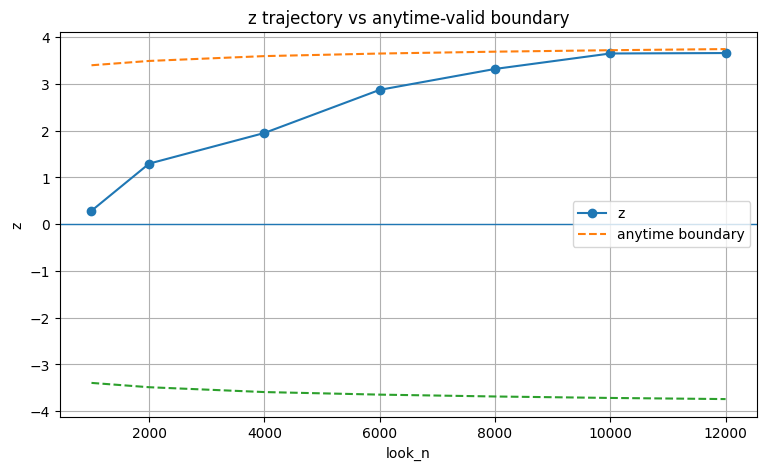

In [5]:
# Plot 2: z-trajectory and anytime boundary
z = tab["z"].to_numpy(dtype=float)
b = pd.to_numeric(tab.get("boundary_z"), errors="coerce").to_numpy(dtype=float)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(x, z, marker="o", label="z")
ax.plot(x, b, linestyle="--", label="anytime boundary")
ax.plot(x, -b, linestyle="--")
ax.axhline(0.0, linewidth=1.0)
ax.set_title("z trajectory vs anytime-valid boundary")
ax.set_xlabel("look_n")
ax.set_ylabel("z")
ax.legend(loc="best")
plt.show()

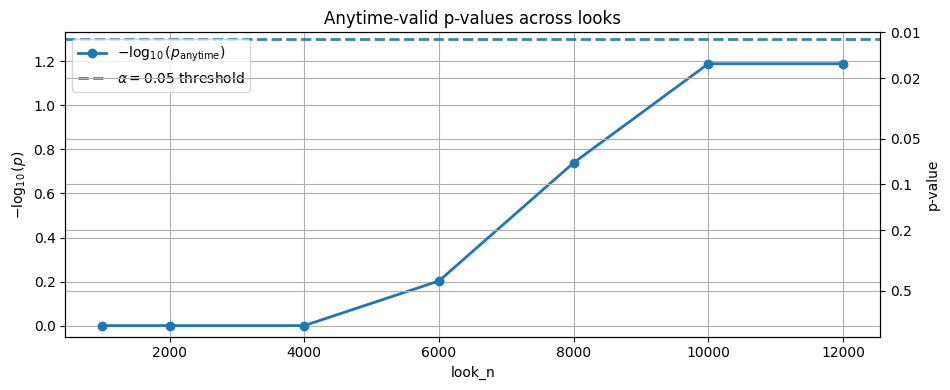

In [8]:
# Plot 3: anytime p-values across looks (clean -log10 with padding + dual axis)
p_any = pd.to_numeric(tab.get("p_anytime"), errors="coerce").to_numpy(dtype=float)

eps = 1e-12
p_clip = np.clip(p_any, eps, 1.0)
y = -np.log10(p_clip)

thr = -np.log10(alpha)

fig = plt.figure(figsize=(9, 4))
ax = fig.add_subplot(111)

ax.plot(x, y, marker="o", linewidth=2, label=r"$-\log_{10}(p_\mathrm{anytime})$")
ax.axhline(thr, linestyle="--", linewidth=2, alpha=0.9, label=rf"$\alpha={alpha}$ threshold")

ax.set_title("Anytime-valid p-values across looks")
ax.set_xlabel("look_n")
ax.set_ylabel(r"$-\log_{10}(p)$")

y_min = float(np.nanmin(y))
y_max = float(np.nanmax(y))
pad = 0.12 * max(1.0, (y_max - y_min))
ax.set_ylim(max(-0.05, y_min - pad), y_max + pad)

ax.legend(loc="upper left")
plt.tight_layout()

axr = ax.twinx()
p_ticks = np.array([0.5, 0.2, 0.1, 0.05, 0.02, 0.01])
y_ticks = -np.log10(p_ticks)
axr.set_yticks(y_ticks)
axr.set_yticklabels([f"{pt:g}" for pt in p_ticks])
axr.set_ylabel("p-value")

plt.show()

## 2) Simulation: optional stopping without breaking alpha
We estimate empirical type I error under the null when a user stops as soon as the anytime rule rejects.

Empirical type I error (CS anytime-valid): 0.004
Average stop look (null): 7977.6


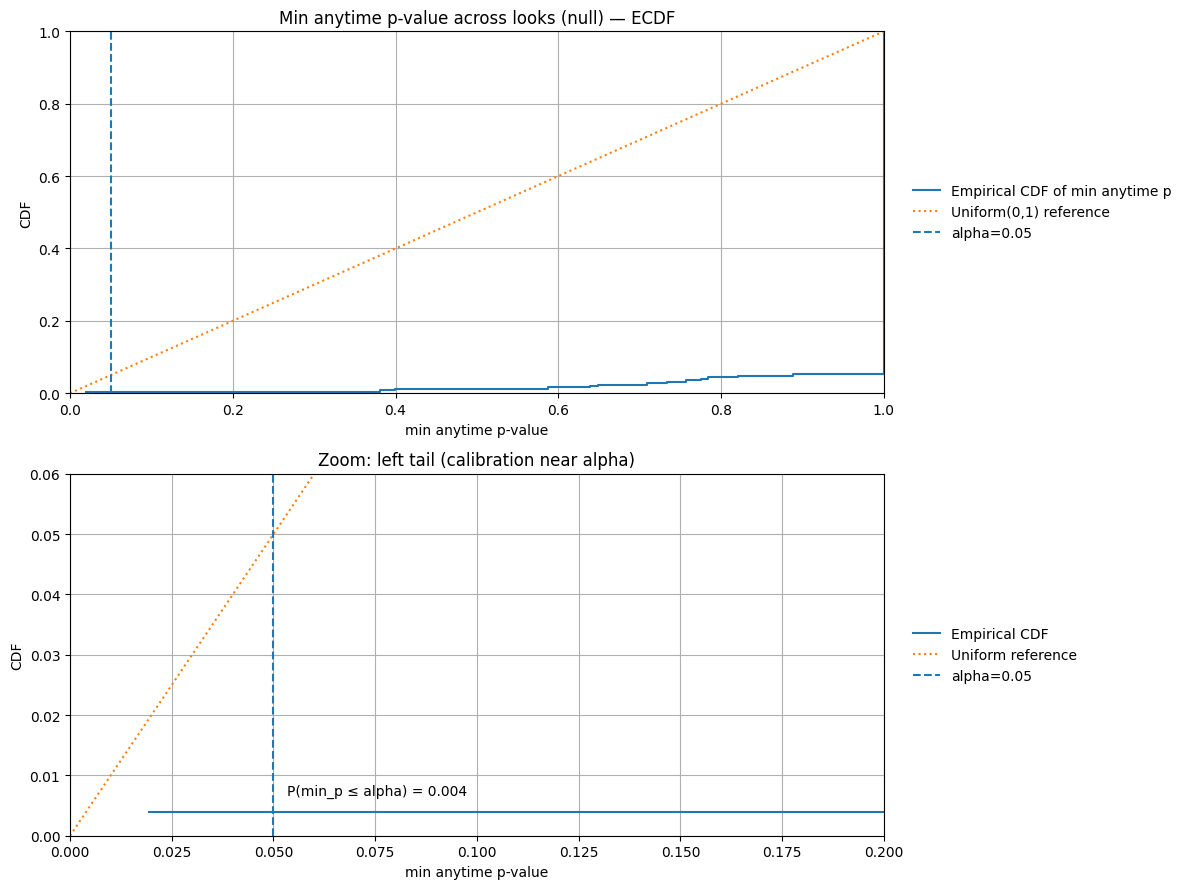

In [12]:
n_sims = 250
N = 8000
looks = [800, 1600, 2400, 3200, 4000, 6000, 8000]
alpha = 0.05

spec = SequentialSpec(group_col="group", control_label="control", test_label="test", y_col="y", timestamp_col="timestamp")
schedule = LookSchedule(looks=looks)
cfg_cs = SequentialConfig(
    mode=SequentialMode.CONFIDENCE_SEQUENCE,
    alpha=alpha,
    two_sided=True,
    effect_direction=EffectDirection.TWO_SIDED,
    min_n_per_group=50,
    var_floor=1e-12,
)

reject = []
stop_looks = []
min_p = []

for s in range(n_sims):
    df0 = simulate_ab_stream(SequentialSimConfig(n=N, effect=0.0, noise_sd=1.0, heavy_tail=False, drift=False, seed=3000 + s, ratio=False))
    lt, _ = build_look_table_mean(df0, spec, schedule, cfg_cs)
    res0 = run_confidence_sequence(lt, cfg_cs)
    tab0 = res0.look_table
    reject.append(res0.decision == "reject")
    stop_looks.append(res0.stop_look if res0.stop_look is not None else looks[-1])
    p_any = pd.to_numeric(tab0.get("p_anytime"), errors="coerce").to_numpy(dtype=float)
    min_p.append(float(np.nanmin(p_any)))

type1 = float(np.mean(reject))
avg_stop = float(np.mean(stop_looks))

print("Empirical type I error (CS anytime-valid):", type1)
print("Average stop look (null):", avg_stop)

min_p_arr = np.asarray(min_p, dtype=float)

x = np.sort(min_p_arr)
y = np.arange(1, len(x) + 1) / len(x)

type1_hat = float(np.mean(min_p_arr <= alpha))

fig = plt.figure(figsize=(12, 9))

ax1 = fig.add_subplot(2, 1, 1)
ax1.step(x, y, where="post", label="Empirical CDF of min anytime p")
ax1.plot([0, 1], [0, 1], linestyle=":", label="Uniform(0,1) reference")
ax1.axvline(alpha, linestyle="--", label=f"alpha={alpha}")

ax1.set_title("Min anytime p-value across looks (null) — ECDF")
ax1.set_xlabel("min anytime p-value")
ax1.set_ylabel("CDF")
ax1.set_xlim(0, 1)
ax1.set_ylim(0, 1)

ax1.legend(loc="center left", bbox_to_anchor=(1.02, 0.5), frameon=False)

ax2 = fig.add_subplot(2, 1, 2)
ax2.step(x, y, where="post", label="Empirical CDF")
ax2.plot([0, 0.2], [0, 0.2], linestyle=":", label="Uniform reference")
ax2.axvline(alpha, linestyle="--", label=f"alpha={alpha}")

ax2.annotate(
    f"P(min_p ≤ alpha) = {type1_hat:.3f}",
    xy=(alpha, type1_hat),
    xytext=(10, 10),        
    textcoords="offset points",
    ha="left",
    va="bottom",
)

ax2.set_title("Zoom: left tail (calibration near alpha)")
ax2.set_xlabel("min anytime p-value")
ax2.set_ylabel("CDF")
ax2.set_xlim(0, 0.2)

ax2.set_ylim(0, max(0.06, min(0.2, type1_hat * 3 + 0.02)))

ax2.legend(loc="center left", bbox_to_anchor=(1.02, 0.5), frameon=False)

plt.tight_layout()
plt.show()

## Interpretation
- A confidence sequence provides a time-uniform band: at any time you stop, the band remains valid at level (1−α).
- Anytime p-values remain super-uniform under the null even with optional stopping.

Practical takeaway (v1):

- If you need to monitor continuously (or with flexible looks) and still preserve a frequentist guarantee, use CS/anytime-valid outputs.

## Result summary

We evaluated an anytime-valid (confidence sequence / anytime p-value) approach for sequential monitoring on a two-group mean metric.

Setup:
- Schedule (K = 7): `[800, 1600, 2400, 3200, 4000, 6000, 8000]`
- Two-sided α = 0.05
- Null simulation (true effect = 0), with optional stopping allowed (stop as soon as the anytime-valid rule rejects)

Empirical calibration under the null (n_sims = 250):
- Empirical type I error (CS anytime-valid): **0.004**
- Average stop look (null): **7977.6** (i.e., most runs do not stop early and finish near the maximum sample size)

Interpretation:
- The procedure is **strongly conservative** in this configuration: the observed false positive rate (**0.4%**) is far below the nominal **5%** level.
- This conservative behavior implies a clear trade-off: **strong error control** and safe peeking come at the cost of **rare early rejections** (and thus limited early stopping under the null, and potentially reduced sensitivity under small effects).

Key takeaway:
- Confidence sequences provide **anytime-valid uncertainty** and enable safe monitoring/stopping, but boundary choice matters: conservative anytime-valid boundaries can materially reduce early decisions.